In [8]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from ms_deisotope import deconvolute_peaks, averagine, scoring
from ms_deisotope.deconvolution import peak_retention_strategy
from os.path import expanduser
import peakutils
import pickle

In [9]:
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
experiment_name = 'P3856'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

# RESULTS_DIR = '/media/big-ssd/results-P3856'
# IDENTS_PASEF_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-20-02-44-34/identifications-pasef'.format(RESULTS_DIR)

IDENTS_PASEF_DIR = '{}/identifications-pasef'.format(EXPERIMENT_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

In [10]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

In [11]:
# load the features identified
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_df = d['identifications_df']

In [13]:
idents_df['excluded'] = idents_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_df = idents_df[(idents_df.excluded == False)]

In [59]:
print('{} identifications'.format(len(idents_df)))

37251 identifications


In [66]:
idents_df[idents_df.deconvolution_score < 50].sample(n=5)

,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,intensity_with_saturation_correction,...,percolator PEP,total matches/spectrum,sequence,protein id,flanking aa,observed_monoisotopic_mass,theoretical_peptide_mass,mass_accuracy_ppm,mass_error,excluded
70770,610.830626,610.869537,737.0,719,738,1862.687551,1856.866556,1864.805596,676,676,...,1.000000,14416.1,SLPPPKLTDPR,"sp|E9PQ53|NDUCR_HUMAN,sp|O95298|NDUC2_HUMAN",RL,1219.688428,1219.692400,-3.256156,-0.003972,False
65477,1022.905225,1022.970385,103.0,91,135,2046.851224,2041.559389,2052.145356,770,770,...,1.000000,14416.1,SYM[15.9949]AQM[15.9949]DQELAHTCISK,sp|O95905|ECD_HUMAN,KS,2043.862533,2043.869964,-3.635708,-0.007431,False
63598,707.311505,707.356562,592.0,551,625,1781.706814,1780.119303,1783.824315,1251,1251,...,1.000000,14416.1,KCM[15.9949]PR,sp|Q7Z3Z4|PIWL4_HUMAN,KF,706.328480,706.325464,4.270062,0.003016,False
65311,1111.488535,1111.559338,149.0,114,183,1826.700287,1825.642295,1830.934242,801,801,...,1.000000,14416.1,SYKCEECGKAFLWSSTLR,sp|Q05481|ZNF91_HUMAN,KR,2221.034214,2221.029628,2.064989,0.004586,False
65476,947.427179,947.487531,550.0,523,575,2053.204608,2048.971470,2057.967525,1482,1482,...,0.953063,14416.1,WNGLLSAMADADHFDIHFPLDLDVK,sp|Q9NRQ2|PLS4_HUMAN,KM,2839.356736,2839.363900,-2.522983,-0.007164,False


In [67]:
# selected_ident = idents_df.iloc[35000]
selected_ident = idents_df.loc[65477]

#### retention time similarity

In [80]:
max_intensity = 0
min_rt = np.finfo(0.0).max
max_rt = np.finfo(0.0).min
for isotope in selected_ident.isotopic_peaks:
    rt_df = pd.DataFrame(isotope['rt_df'])
    max_intensity = max(max_intensity, rt_df.intensity.max())
    max_rt = max(max_rt, rt_df.retention_time_secs.max())
    min_rt = min(min_rt, rt_df.retention_time_secs.min())

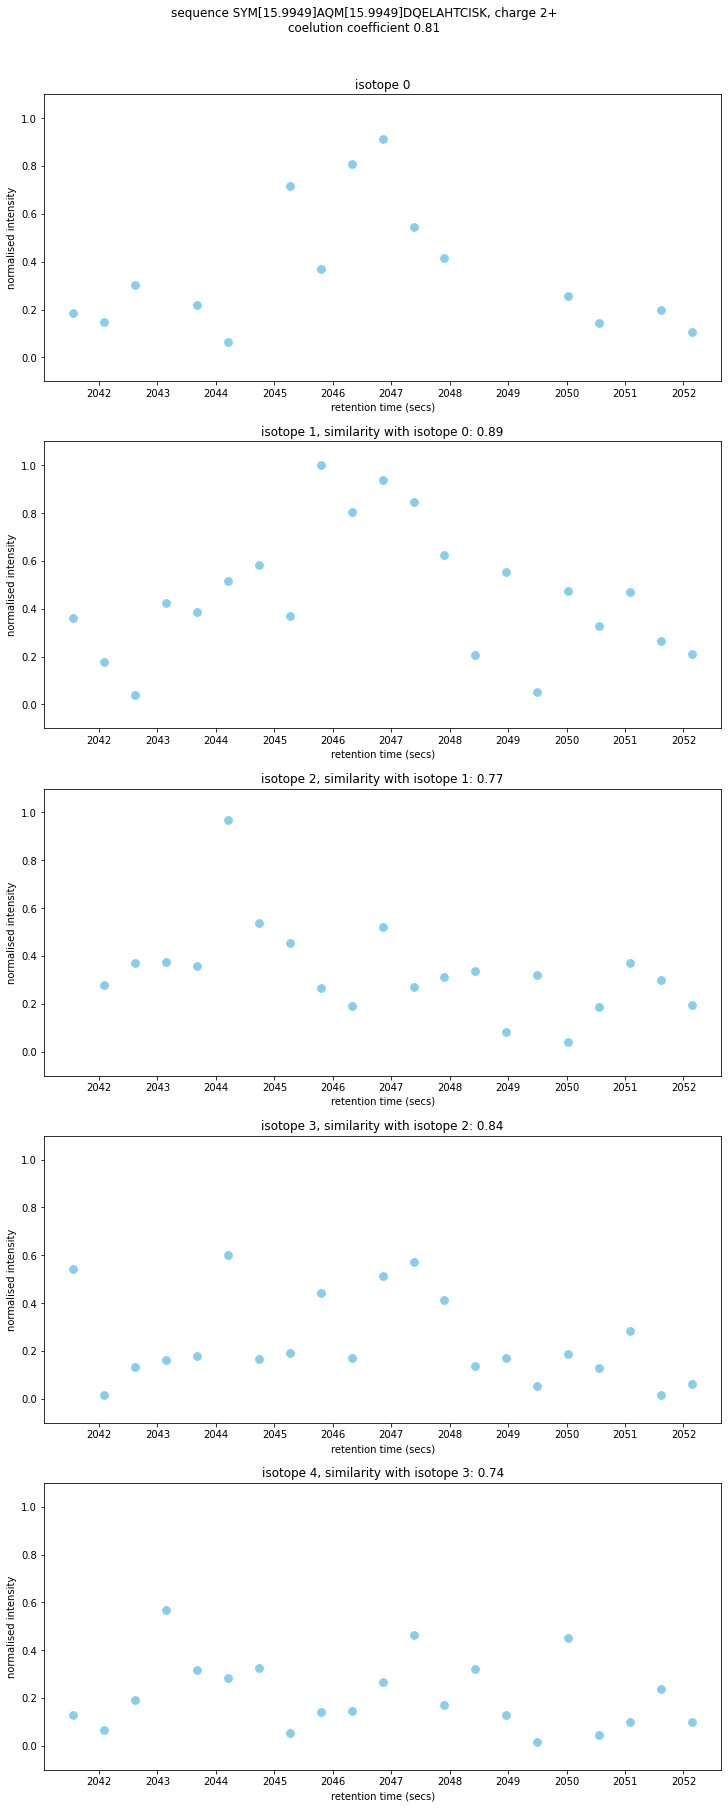

In [83]:
f, axarr = plt.subplots(nrows=len(selected_ident.isotopic_peaks), ncols=1, constrained_layout=True)
f.suptitle('sequence {}, charge {}+\ncoelution coefficient {}'.format(selected_ident.sequence, selected_ident.charge, round(selected_ident.coelution_coefficient,2), fontsize=18))
f.set_figheight(len(selected_ident.isotopic_peaks)*5)
f.set_figwidth(10)

# plot the features derived from deconvoluting the peaks
for idx,isotope in enumerate(selected_ident.isotopic_peaks):
    if len(selected_ident.isotopic_peaks) > 1:
        ax = axarr[idx]  # row, column
    else:
        ax = axarr

    # plot the raw data
    rt_df = pd.DataFrame(isotope['rt_df'])
    rt_df['normalised_intensity'] = rt_df.intensity / max_intensity
    ax.scatter(rt_df.retention_time_secs, rt_df.normalised_intensity, s=60, c='skyblue', label='summed points')

    nearest = 1.0
    range_l = round(rt_df.retention_time_secs.min() / nearest) * nearest
    range_u = round(rt_df.retention_time_secs.max() / nearest) * nearest
    ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

    ax.set_xlabel('retention time (secs)')
    ax.set_ylabel('normalised intensity')
    # ax.legend(loc='best')
    if idx > 0:
        ax.set_title('isotope {}, similarity with isotope {}: {}'.format(idx, idx-1, round(isotope['similarity_rt'],2)))
    else:
        ax.set_title('isotope {}'.format(idx))
    ax.set_xlim((min_rt-0.5,max_rt+0.5))
    ax.set_ylim((-0.1,1.1))
plt.show()

#### mobility similarity

In [84]:
max_intensity = 0
min_scan = np.iinfo(0).max
max_scan = np.iinfo(0).min
for isotope in selected_ident.isotopic_peaks:
    scan_df = pd.DataFrame(isotope['scan_df'])
    max_intensity = max(max_intensity, scan_df.intensity.max())
    max_scan = max(max_scan, scan_df.scan.max())
    min_scan = min(min_scan, scan_df.scan.min())    

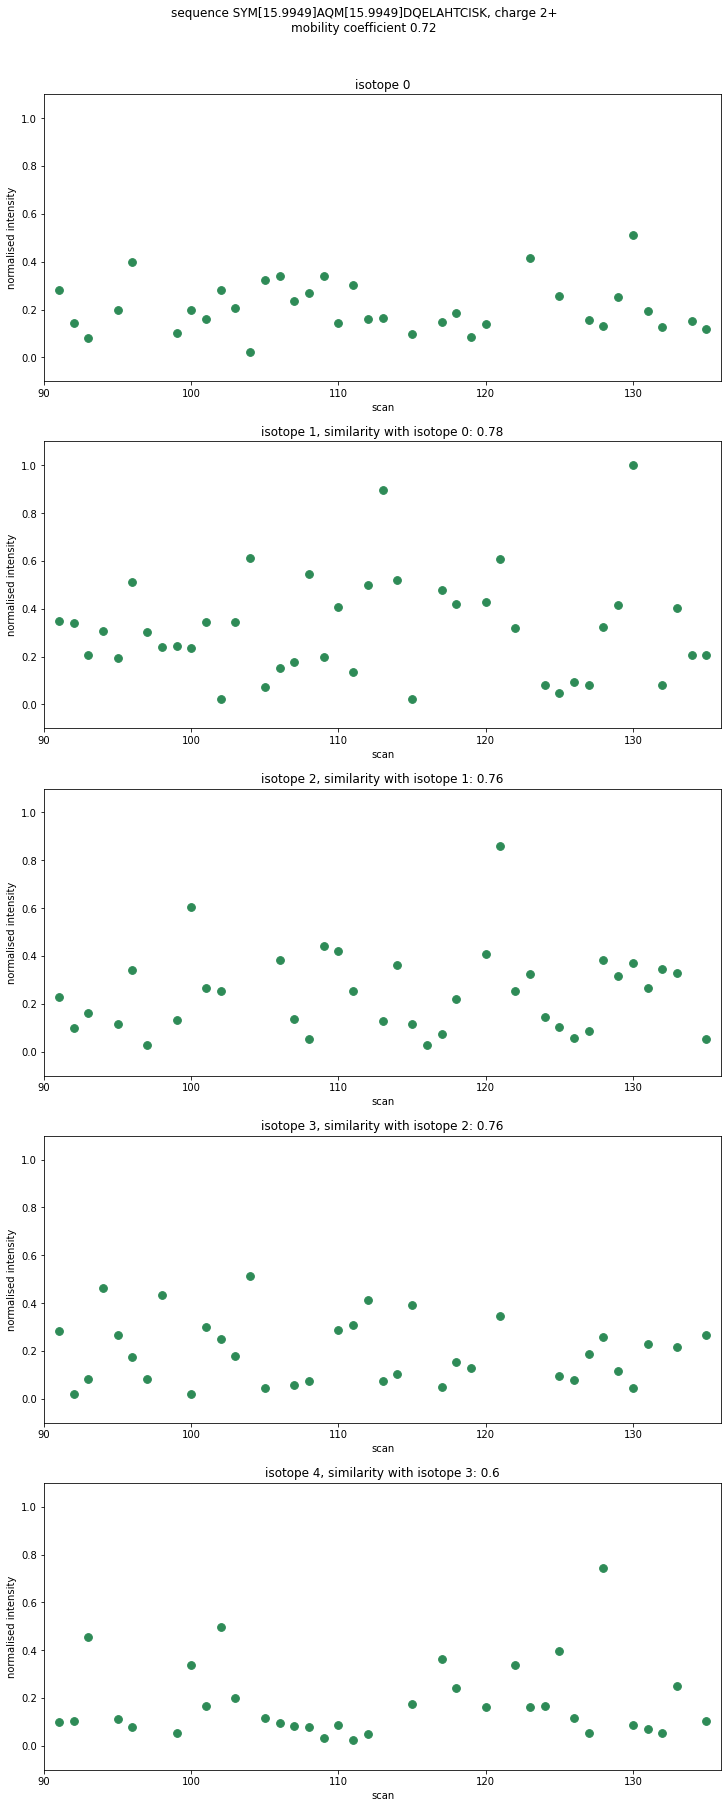

In [85]:
f, axarr = plt.subplots(nrows=len(selected_ident.isotopic_peaks), ncols=1, constrained_layout=True)
f.suptitle('sequence {}, charge {}+\nmobility coefficient {}'.format(selected_ident.sequence, selected_ident.charge, round(selected_ident.mobility_coefficient,2), fontsize=18))
f.set_figheight(len(selected_ident.isotopic_peaks)*5)
f.set_figwidth(10)

# plot the features derived from deconvoluting the peaks
for idx,isotope in enumerate(selected_ident.isotopic_peaks):
    if len(selected_ident.isotopic_peaks) > 1:
        ax = axarr[idx]  # row, column
    else:
        ax = axarr

    # plot the raw data
    scan_df = pd.DataFrame(isotope['scan_df'])
    scan_df['normalised_intensity'] = scan_df.intensity / max_intensity
    ax.scatter(scan_df.scan, scan_df.normalised_intensity, s=60, c='seagreen', label='summed points')

    nearest = 10.0
    range_l = round(scan_df.scan.min() / nearest) * nearest
    range_u = round(scan_df.scan.max() / nearest) * nearest
    ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

    ax.set_xlabel('scan')
    ax.set_ylabel('normalised intensity')
    # ax.legend(loc='best')
    if idx > 0:
        ax.set_title('isotope {}, similarity with isotope {}: {}'.format(idx, idx-1, round(isotope['similarity_scan'],2)))
    else:
        ax.set_title('isotope {}'.format(idx))
    ax.set_xlim((min_scan-1,max_scan+1))
    ax.set_ylim((-0.1,1.1))
plt.show()